In [ ]:
"""The objective of this file is to show how I understand DNN and from the MBA perspective how to apply Machine Learning, unbrella term of AI, in the real business especially financa field."""

In [1]:
# Simply loading data & preprocessing
# In handling financal asset historical data, usually preprocessing is looking into dataset for sanity check and feature engineering 
# In feature engineering, like in other field of analytic, it's more close to art than technique. Plus, I believe this is where one can compete with big companeis with less powerful personal pc

# But for now, I will only use simple loading and a function to add lags with a few technical analysis. 


In [46]:
import pandas as pd
import numpy as np

In [84]:
# load data

# option1: yfinance
import yfinance as yf

#slow af
data = yf.download('AAPL', start="2020-01-01")
data.head()

# def stock_price_downloader() -> pd.DataFrame:
#     pass
# should give the last date 

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441452,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018684,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844360,132079200


In [85]:
#remove lookahead fautl by dropping and replace 'Close' by Adj Close
data.drop(columns=['Close'], inplace= True)
data.rename(columns={'Adj Close':'Close'}, inplace=True)

In [86]:
def add_lags(data, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df['Close'] / df['Close'].shift(1))
    df['sma'] = df['Close'].rolling(window).mean()
    df['min'] = df['Close'].rolling(window).min()
    df['max'] = df['Close'].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = ['r', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [87]:
df, cols = add_lags(data, lags=5)

In [88]:
df.head()

,Open,High,Low,Close,Volume,r,sma,min,max,mom,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-07,80.592499,80.849998,79.500000,78.130852,117684000,-0.013686,77.164165,75.176613,79.207512,0.001770,...,0.003506,0.003722,0.003080,0.001853,0.001502,0.018692,0.018816,0.018877,0.017621,0.017787
2020-02-10,78.544998,80.387497,78.462502,78.501930,109348800,0.004738,77.310095,75.176613,79.207512,0.001894,...,0.001770,0.003506,0.003722,0.003080,0.001853,0.018592,0.018692,0.018816,0.018877,0.017621
2020-02-11,80.900002,80.974998,79.677498,78.028320,94323200,-0.006051,77.351604,75.176613,79.207512,0.000535,...,0.001894,0.001770,0.003506,0.003722,0.003080,0.018603,0.018592,0.018692,0.018816,0.018877
2020-02-12,80.367500,81.805000,80.367500,79.881310,113730400,0.023470,77.537883,75.176613,79.881310,0.002388,...,0.000535,0.001894,0.001770,0.003506,0.003722,0.018110,0.018603,0.018592,0.018692,0.018816
2020-02-13,81.047501,81.555000,80.837502,79.312469,94747600,-0.007147,77.712039,75.176613,79.881310,0.002245,...,0.002388,0.000535,0.001894,0.001770,0.003506,0.018480,0.018110,0.018603,0.018592,0.018692


In [89]:
# TF Model Building

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2


In [91]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)


In [92]:
def create_dnn_model(hidden_layers=2, hidden_units=128, dropout=False, rate=0.3,
                regularize=False, reg=l2(0.0005),
                optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim,
                 activity_regularizer=reg,  
                 activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hidden_layers):
        model.add(Dense(hidden_units, activation='relu',
                     activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [93]:
np.bincount(df['d'])

array([469, 514])

In [94]:
model = create_dnn_model(hidden_layers=2, hidden_units=128)

In [95]:
mu, std = df.mean(), df.std()
df_ = (df - mu) / std

In [96]:
model.fit(df_[cols], df['d'], 
        epochs=20, validation_split=0.2, shuffle=False)

Epoch 1/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4746 - val_loss: 0.7030 - val_accuracy: 0.4619
Epoch 2/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6910 - accuracy: 0.5318 - val_loss: 0.7111 - val_accuracy: 0.4518
Epoch 3/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5369 - val_loss: 0.7174 - val_accuracy: 0.4569
Epoch 4/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6829 - accuracy: 0.5509 - val_loss: 0.7222 - val_accuracy: 0.4569
Epoch 5/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6797 - accuracy: 0.5674 - val_loss: 0.7257 - val_accuracy: 0.4569
Epoch 6/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6768 - accuracy: 0.5751 - val_loss: 0.7289 - val_accuracy: 0.4569
Epoch 7/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6739 - accuracy: 0.5738 - val_loss: 0.7319 - val_accuracy: 0.4569
Epoch 8/20
25/25 [==

In [97]:
model.evaluate(df_[cols], df['d'])

31/31 [==============================] - 0s 355us/step - loss: 0.6680 - accuracy: 0.5992


[0.6680329442024231, 0.5991861820220947]

31/31 [==============================] - 0s 377us/step


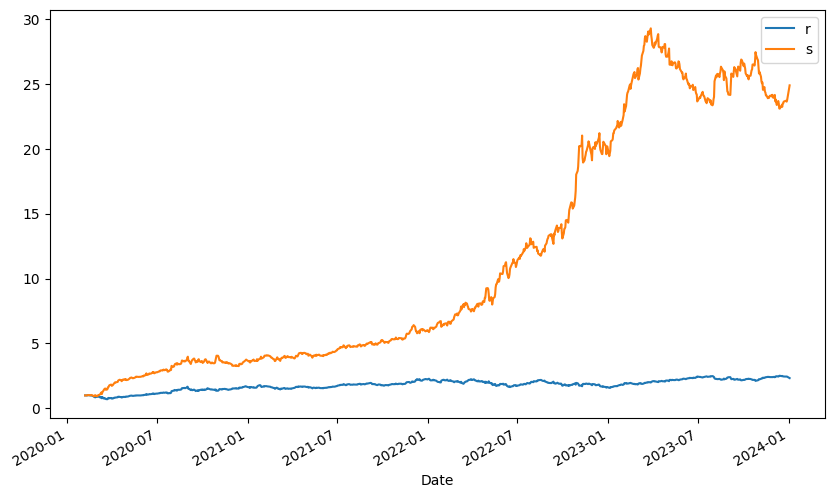

In [98]:
df['p'] = np.where(model.predict(df_[cols]) > 0.5, 1, 0)
df['p'] = np.where(df['p'] == 1, 1, -1)
df['s'] = df['p'] * df['r']
df[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

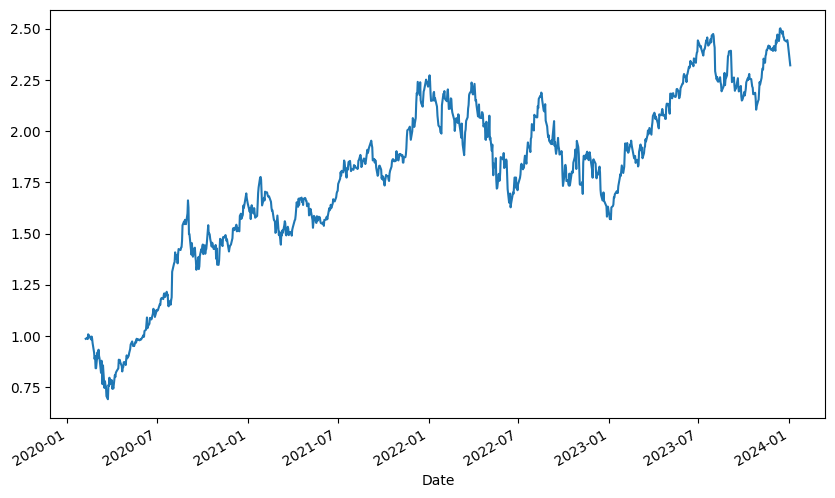

In [99]:
df['r'].cumsum().apply(np.exp).plot(figsize=(10, 6));

<Axes: xlabel='Date'>

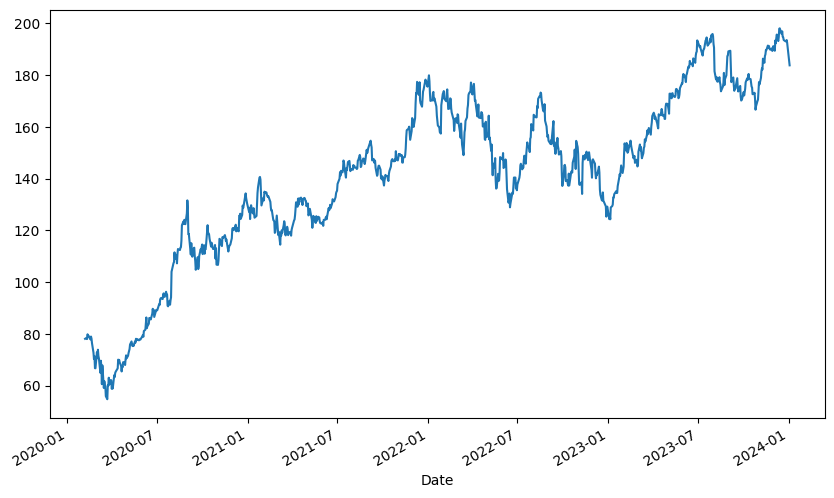

In [100]:
df['Close'].plot(figsize=(10, 6))

In [ ]:
# I know it's too unrealistic

# what if long only?
# - backtesting

---

In [103]:
def convert_a_c(x):
    if x == 1: return True
    elif x == 3: return False
    else: return x

In [104]:
t_df['b'] = t_df['a'].map(convert_a_c)

In [105]:
t_df

,a,b
0,1,True
1,2,2
2,3,False


---

In [125]:
#longonly
def func_decision(x):
    if x<0.3: return -1
    elif x>0.6: return 1
    else: return 0

df['p'] = model.predict(df_[cols])
df['p_'] = df['p'].map(func_decision)



31/31 [==============================] - 0s 387us/step


In [126]:
df['p_'].value_counts()
# df['p'].hist()

p_
 0    802
 1    120
-1     61
Name: count, dtype: int64

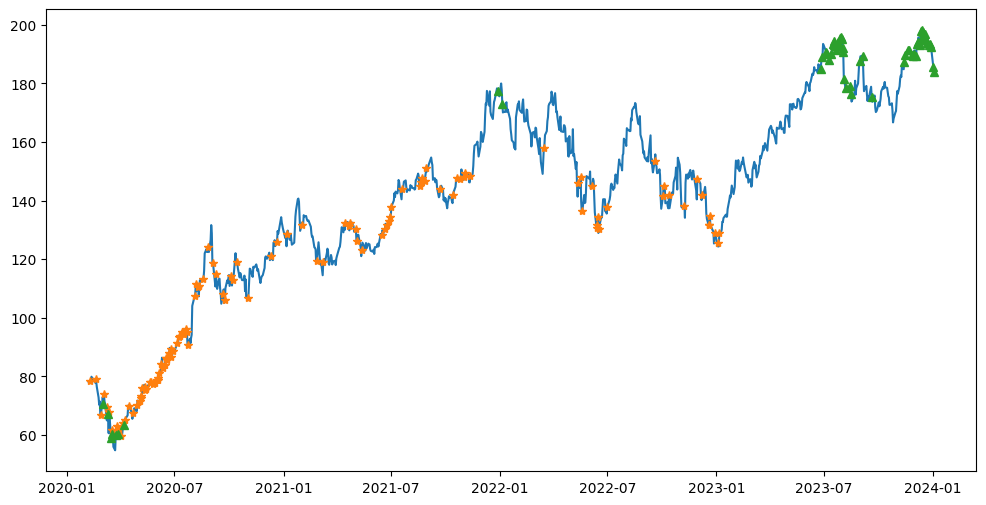

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Close'])
plt.plot(df[df['p_']==1]['Close'], '*')
plt.plot(df[df['p_']==-1]['Close'], '^')

In [ ]:
from backtesting import 